#### This notebook examines the abrupt experiments which follow a 500 year spinup using ACCESS-OM2-1.


The downward longwave and SAT forcing fields are modified as globally uniform, time-independent constant perturbations of $\pm$ 8 W/m^2 and $\pm$ 1.5C, respectively, following _Stewart and Hogg (2019)_. The model is also forced with the relative humidity (which we seek to keep constant between perturbation and control) instead of the specific humidity, since modifying the SAT fields will change the specific humidity.

In [2]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit

from dask.distributed import Client

%matplotlib inline

In [3]:
client = Client()
display(client)

Client Scheduler: tcp://127.0.0.1:45313 Dashboard: /proxy/46119/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [1]:
### Open session

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'

session = cc.database.create_session(db)

NameError: name 'cc' is not defined

In [5]:
cc.querying.get_experiments(session)

,experiment,ncfiles
0,1deg_jra55_ryf_cont,150429
1,output111,2096
2,output112,2096
3,output113,2096
4,output114,2096
5,output115,2096
6,output116,2096
7,output117,2096
8,output118,2096
9,output119,2096


In [8]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

cc.querying.get_variables(session, experiment='1deg_jra55_ryf_rcp45cool_spinup500', frequency='1 monthly')

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
0,ANGLE,angle grid makes with latitude line on U grid,1 monthly,output119/ice/OUTPUT/iceh.2499-12.nc,1200,2400-01-01 00:00:00,2500-01-01 00:00:00
1,ANGLET,angle grid makes with latitude line on T grid,1 monthly,output119/ice/OUTPUT/iceh.2499-12.nc,1200,2400-01-01 00:00:00,2500-01-01 00:00:00
2,HTE,T cell width on East side,1 monthly,output119/ice/OUTPUT/iceh.2499-12.nc,1200,2400-01-01 00:00:00,2500-01-01 00:00:00
3,HTN,T cell width on North side,1 monthly,output119/ice/OUTPUT/iceh.2499-12.nc,1200,2400-01-01 00:00:00,2500-01-01 00:00:00
4,NCAT,category maximum thickness,1 monthly,output119/ice/OUTPUT/iceh.2499-12.nc,1200,2400-01-01 00:00:00,2500-01-01 00:00:00
5,TLAT,T grid center latitude,1 monthly,output119/ice/OUTPUT/iceh.2499-12.nc,1200,2400-01-01 00:00:00,2500-01-01 00:00:00
6,TLON,T grid center longitude,1 monthly,output119/ice/OUTPUT/iceh.2499-12.nc,1200,2400-01-01 00:00:00,2500-01-01 00:00:00
7,Tair_m,air temperature,1 monthly,output119/ice/OUTPUT/iceh.2499-12.nc,1200,2400-01-01 00:00:00,2500-01-01 00:00:00
8,Tsfc_m,snow/ice surface temperature,1 monthly,output119/ice/OUTPUT/iceh.2499-12.nc,1200,2400-01-01 00:00:00,2500-01-01 00:00:00
9,ULAT,U grid center latitude,1 monthly,output119/ice/OUTPUT/iceh.2499-12.nc,1200,2400-01-01 00:00:00,2500-01-01 00:00:00


## Analysis

In what follows, only the period 2400-2500 will be analysed, since this is the period over which the perturbations experiments have been run.

In [12]:
### Control

expt = '1deg_jra55_ryf_cont'
cont = cc.querying.get_variables(session, experiment = expt)
yr_beg = '2399-01-16'
yr_end = '2499-12-16'

#3D temperature array
temp_cont = cc.querying.getvar(expt, 'temp', session, frequency = '1 monthly').sel(time = slice(yr_beg, None)).chunk(chunks='auto')
for i in range(1,10):
    da = cc.querying.getvar('output11{}'.format(i), 'temp', session, frequency = '1 monthly')#[:-1]
    temp_cont = xr.concat([temp_cont, da],dim='time')

# Global average temp    
GAT_cont = cc.querying.getvar(expt, 'temp_global_ave', session).sel(time = slice(yr_beg, None)).groupby('time.year').mean('time')[:-1].chunk(chunks='auto') # Cuts off year 2455, included in next array
for i in range(1,10):
    da = cc.querying.getvar('output11{}'.format(i), 'temp_global_ave', session)[:-1].groupby('time.year').mean('time')
    GAT_cont = xr.concat([GAT_cont, da], dim='year')
    
# SST
SST_cont = cc.querying.getvar(expt, 'temp_surface_ave', session).sel(time = slice(yr_beg, None)).groupby('time.year').mean('time')[:-1]
for i in range(1,10):
    da = cc.querying.getvar('output11{}'.format(i), 'temp_surface_ave', session)[:-1].groupby('time.year').mean('time')
    SST_cont = xr.concat([SST_cont, da], dim='year')

In [10]:
### Cool

expt = '1deg_jra55_ryf_rcp45cool_spinup500'
cool = cc.querying.get_variables(session, experiment = expt)

temp_cool = cc.querying.getvar(expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto') 
GAT_cool = cc.querying.getvar(expt, 'temp_global_ave', session).groupby('time.year').mean('time')[:-1].chunk(chunks='auto') # Cuts off 2500, only one entry
SST_cool = cc.querying.getvar(expt, 'temp_surface_ave', session).groupby('time.year').mean('time')[:-1].chunk(chunks='auto') # Cuts off 2500, only one entry

In [11]:
### Warm

expt = '1deg_jra55_ryf_rcp45warm_spinup500'
cool = cc.querying.get_variables(session, experiment = expt)

temp_warm = cc.querying.getvar(expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto')   
GAT_warm = cc.querying.getvar(expt, 'temp_global_ave', session).groupby('time.year').mean('time')[:-1].chunk(chunks='auto')
SST_warm = cc.querying.getvar(expt, 'temp_surface_ave', session).groupby('time.year').mean('time')[:-1]

In [12]:
# Load into memory

GAT_cont = GAT_cont.load()
SST_cont = SST_cont.load()

In [13]:
GAT_cool = GAT_cool.load()
SST_cool = SST_cool.load()

In [14]:
GAT_warm = GAT_warm.load()
SST_warm = SST_warm.load()

In [15]:
### Dedrift using a cubic

def cubic(t, a, b, c, d):
    return a * t**3 + b * t**2 + c * t + d

t = GAT_cont['year'].values
popt, pcov = curve_fit(cubic, t, GAT_cont[:,0])
GAT_trend = cubic(t, *popt)

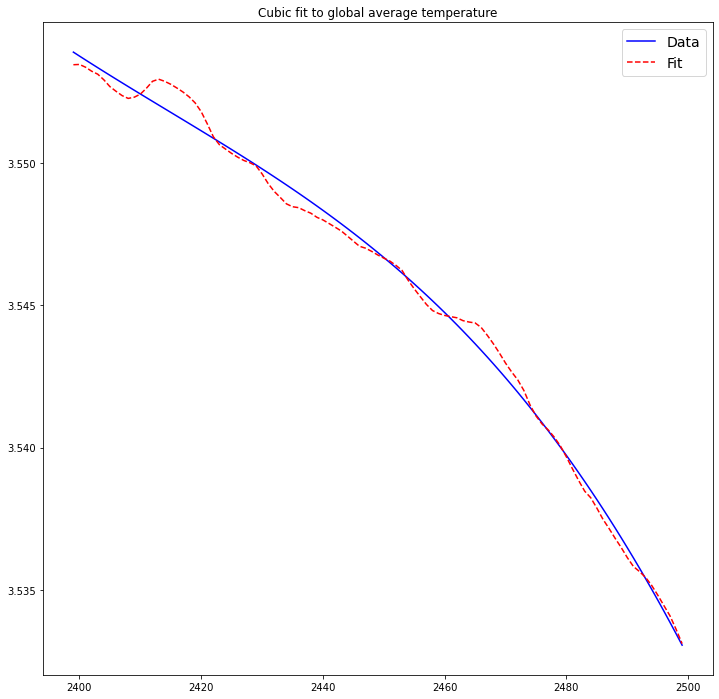

In [16]:
plt.figure(figsize=(12,12))
plt.plot(t, GAT_trend, label='Data', color = 'b')
plt.plot(t, GAT_cont[:,0], label='Fit', color = 'r', linestyle = '--')
plt.title('Cubic fit to global average temperature')
plt.legend(fontsize=14)

Text(0, 0.5, 'Temperature anomaly (K)')

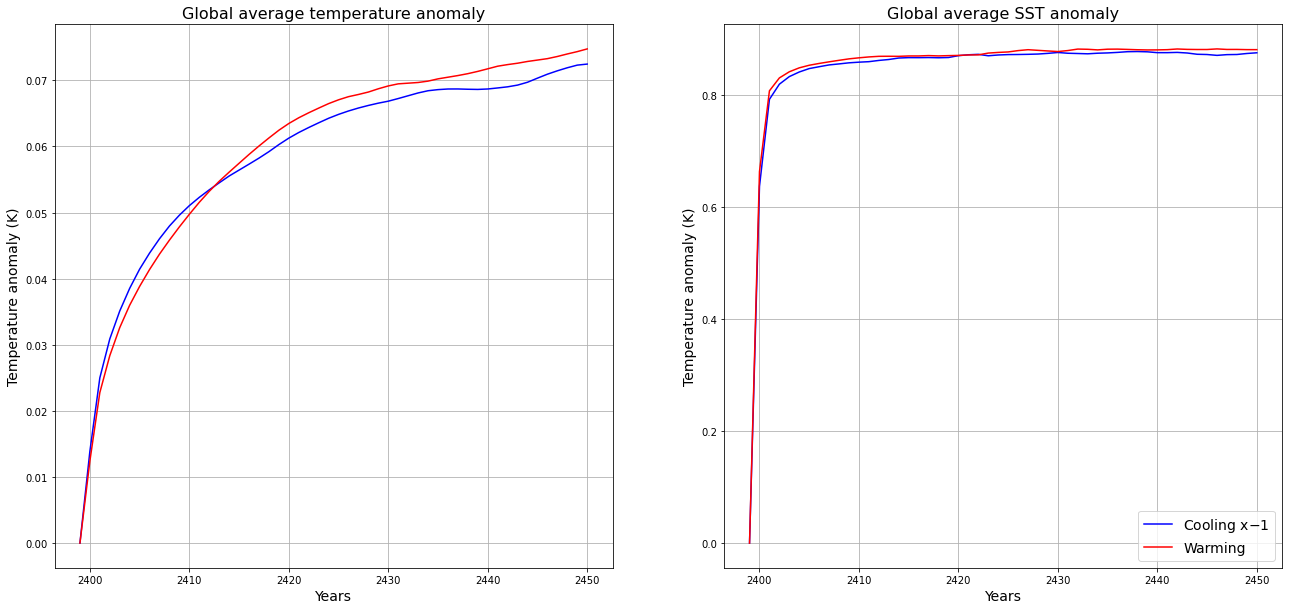

In [17]:
# GAT
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(22,10))
GAT_trend_2399 = xr.DataArray(data=[GAT_trend[0]], dims='year', coords={"year": [2399]})
GAT_cool_plotting = xr.concat([GAT_trend_2399, GAT_cool], dim='year')[:,0]
GAT_warm_plotting = xr.concat([GAT_trend_2399, GAT_warm], dim='year')[:,0]
(GAT_trend[:52] - GAT_cool_plotting[:52]).plot(ax = axs[0], color='b', label='Cooling x$-1$')
(GAT_warm_plotting[:52] - GAT_trend[:52]).plot(ax = axs[0], color='r', label='Warming')
axs[0].grid()
axs[0].set_title('Global average temperature anomaly', fontsize=16)
axs[0].set_xlabel('Years', fontsize=14)
axs[0].set_ylabel('Temperature anomaly (K)', fontsize=14)


# SST
SST_cool_plotting = xr.concat([SST_cont[0,:], SST_cool], dim='year')
SST_warm_plotting = xr.concat([SST_cont[0,:], SST_warm], dim='year')
(SST_cont[:52] - SST_cool_plotting[:52]).plot(ax = axs[1], color='b', label='Cooling x$-1$')
(SST_warm_plotting[:52] - SST_cont[:52]).plot(ax = axs[1], color='r', label='Warming')
axs[1].grid()
axs[1].legend(fontsize=14, loc='lower right')
axs[1].set_title('Global average SST anomaly', fontsize=16)
axs[1].set_xlabel('Years', fontsize=14)
axs[1].set_ylabel('Temperature anomaly (K)', fontsize=14)
#plt.savefig('GAT_SST_spinup500.jpg')

## Surface heat fluxes

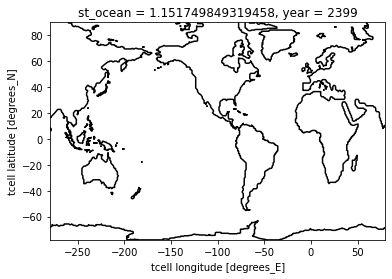

In [18]:
# Get land mask

dset = xr.merge([temp_cont.groupby('time.year').mean(dim='time').isel(year = 0, st_ocean = 0)])
ds = dset
mask_ocean = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.temp)  
mask_land = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.temp)  
mask_array = mask_ocean + mask_land
mask_array.plot.contour(colors = 'k', levels = [2])

In [19]:
### Surface heat flux
# Using 'net_sfc_heating': "surface ocean heat flux coming through coupler and mass transfer"

yr_beg = '2400-01-01'
yr_end = '2449-12-31'
var = 'net_sfc_heating'

expt = '1deg_jra55_ryf_cont'
net_sfc_cont = cc.querying.getvar(expt, var, session).sel(time = slice(yr_beg, yr_end)).chunk(chunks='auto') 

expt = '1deg_jra55_ryf_rcp45cool_spinup500'
net_sfc_cool = cc.querying.getvar(expt, var, session).sel(time = slice(yr_beg, yr_end)).chunk(chunks='auto')

expt = '1deg_jra55_ryf_rcp45warm_spinup500'
net_sfc_warm = cc.querying.getvar(expt, var, session).sel(time = slice(yr_beg, yr_end)).chunk(chunks='auto')

Text(0, 0.5, 'Jm$^{-2}$')

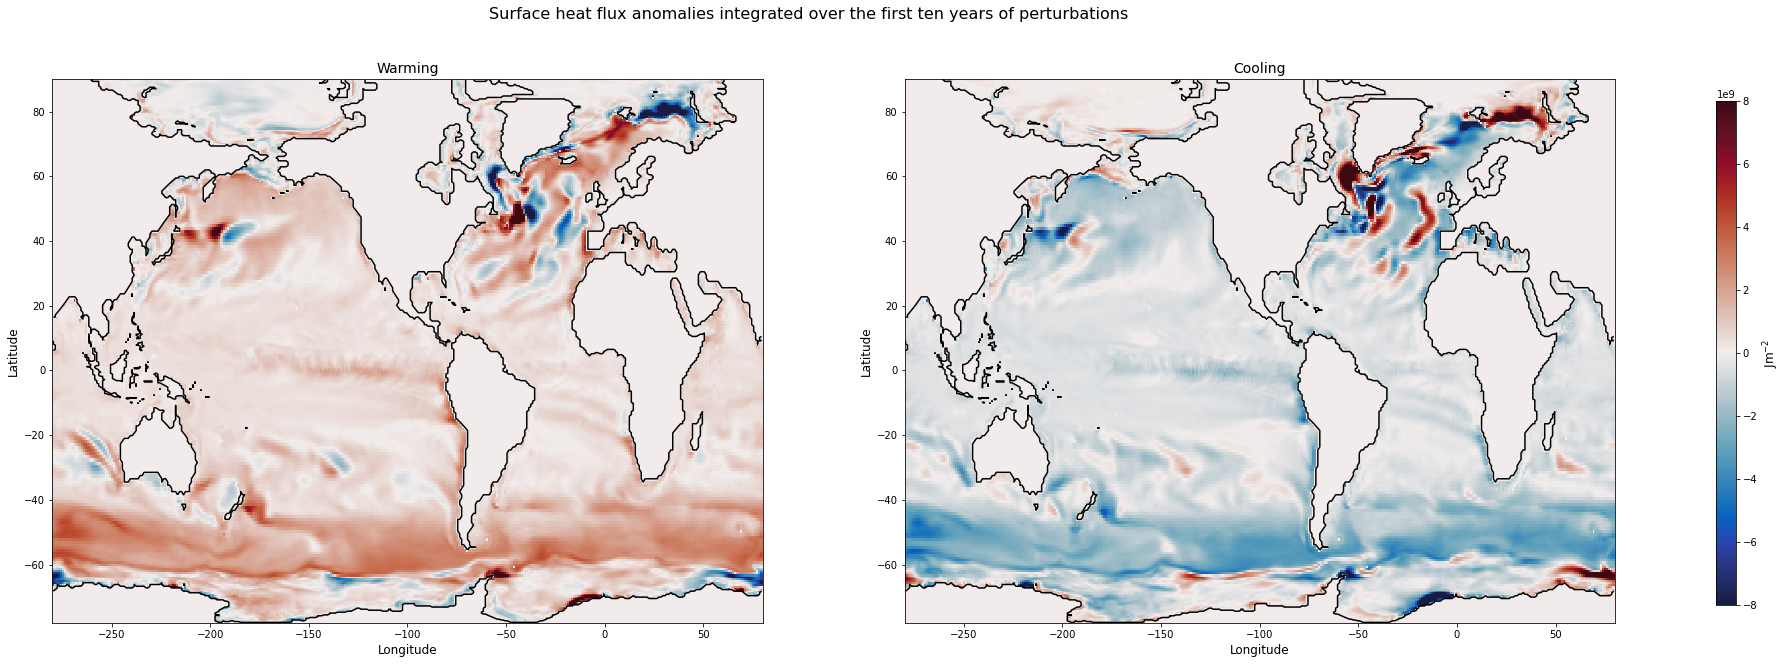

In [21]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(28, 10))
plt.suptitle('Surface heat flux anomalies integrated over the first ten years of perturbations', fontsize=16)
yr_10 = '2410-01-01'

month_length = net_sfc_cont.time.dt.days_in_month
p1 = ((net_sfc_warm - net_sfc_cont) * month_length * 24 * 3600).sel(time = slice(yr_beg, yr_10)).sum('time').plot(ax = axs[0], cmap = cm.cm.balance, vmin = -8e9, vmax = 8e9, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[0])
axs[0].set_title('Warming', fontsize=14)
axs[0].set_ylabel('Latitude', fontsize=12)
axs[0].set_xlabel('Longitude', fontsize=12)

p2 = ((net_sfc_cool - net_sfc_cont) * month_length * 24 * 3600).sel(time = slice(yr_beg, yr_10)).sum('time').plot(ax = axs[1], cmap = cm.cm.balance, vmin = -8e9, vmax = 8e9, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[1])
axs[1].set_title('Cooling', fontsize=14)
axs[1].set_ylabel('Latitude', fontsize=12)
axs[1].set_xlabel('Longitude', fontsize=12)

cb_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
cbar = fig.colorbar(p2, cax = cb_ax)
cbar.ax.set_ylabel('Jm$^{-2}$', fontsize = 12)
#plt.savefig('SHF_10.jpg')

Text(0, 0.5, 'Jm$^{-2}$')

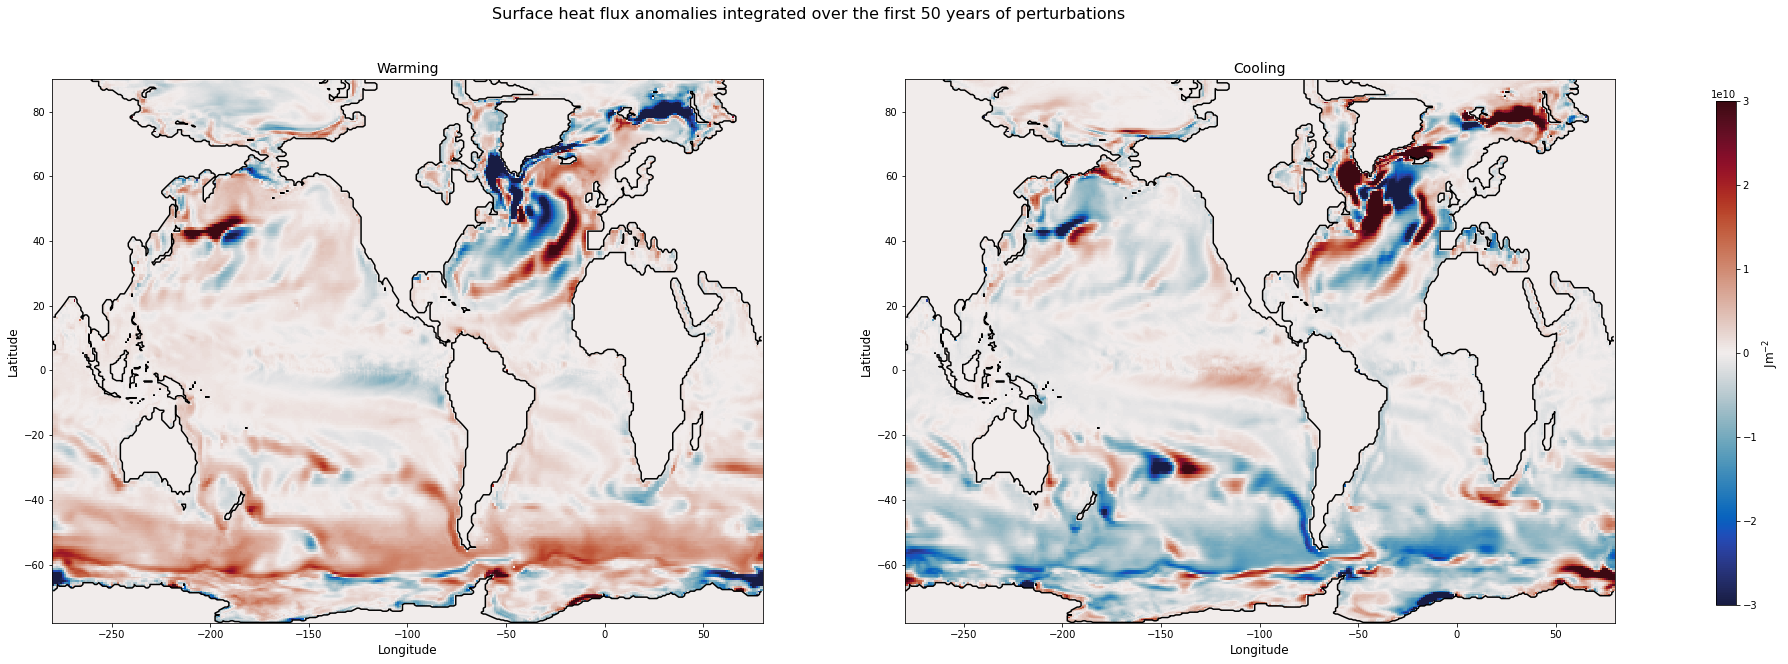

In [22]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(28, 10))
plt.suptitle('Surface heat flux anomalies integrated over the first 50 years of perturbations', fontsize=16)
yr_10 = '2410-01-01'

month_length = net_sfc_cont.time.dt.days_in_month
p1 = ((net_sfc_warm - net_sfc_cont) * month_length * 24 * 3600).sel(time = slice(yr_beg, yr_end)).sum('time').plot(ax = axs[0], cmap = cm.cm.balance, vmin = -3e10, vmax = 3e10, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[0])
axs[0].set_title('Warming', fontsize=14)
axs[0].set_ylabel('Latitude', fontsize=12)
axs[0].set_xlabel('Longitude', fontsize=12)

p2 = ((net_sfc_cool - net_sfc_cont) * month_length * 24 * 3600).sel(time = slice(yr_beg, yr_end)).sum('time').plot(ax = axs[1], cmap = cm.cm.balance, vmin = -3e10, vmax = 3e10, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[1])
axs[1].set_title('Cooling', fontsize=14)
axs[1].set_ylabel('Latitude', fontsize=12)
axs[1].set_xlabel('Longitude', fontsize=12)

cb_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
cbar = fig.colorbar(p2, cax = cb_ax)
cbar.ax.set_ylabel('Jm$^{-2}$', fontsize = 12)
#plt.savefig('SHF_50.jpg')

In [23]:
# Using 'evap_heat': "latent heat flux into ocean"

yr_beg = '2400-01-01'
yr_end = '2449-12-31'
var = 'evap_heat'

expt = '1deg_jra55_ryf_cont'
evap_heat_cont = cc.querying.getvar(expt, var, session).sel(time = slice(yr_beg, yr_end)).chunk(chunks='auto')

expt = '1deg_jra55_ryf_rcp45cool_spinup500'
evap_heat_cool = cc.querying.getvar(expt, var, session).sel(time = slice(yr_beg, yr_end)).chunk(chunks='auto')

expt = '1deg_jra55_ryf_rcp45warm_spinup500'
evap_heat_warm = cc.querying.getvar(expt, var, session).sel(time = slice(yr_beg, yr_end)).chunk(chunks='auto')

Text(0.5, 0, 'Longitude')

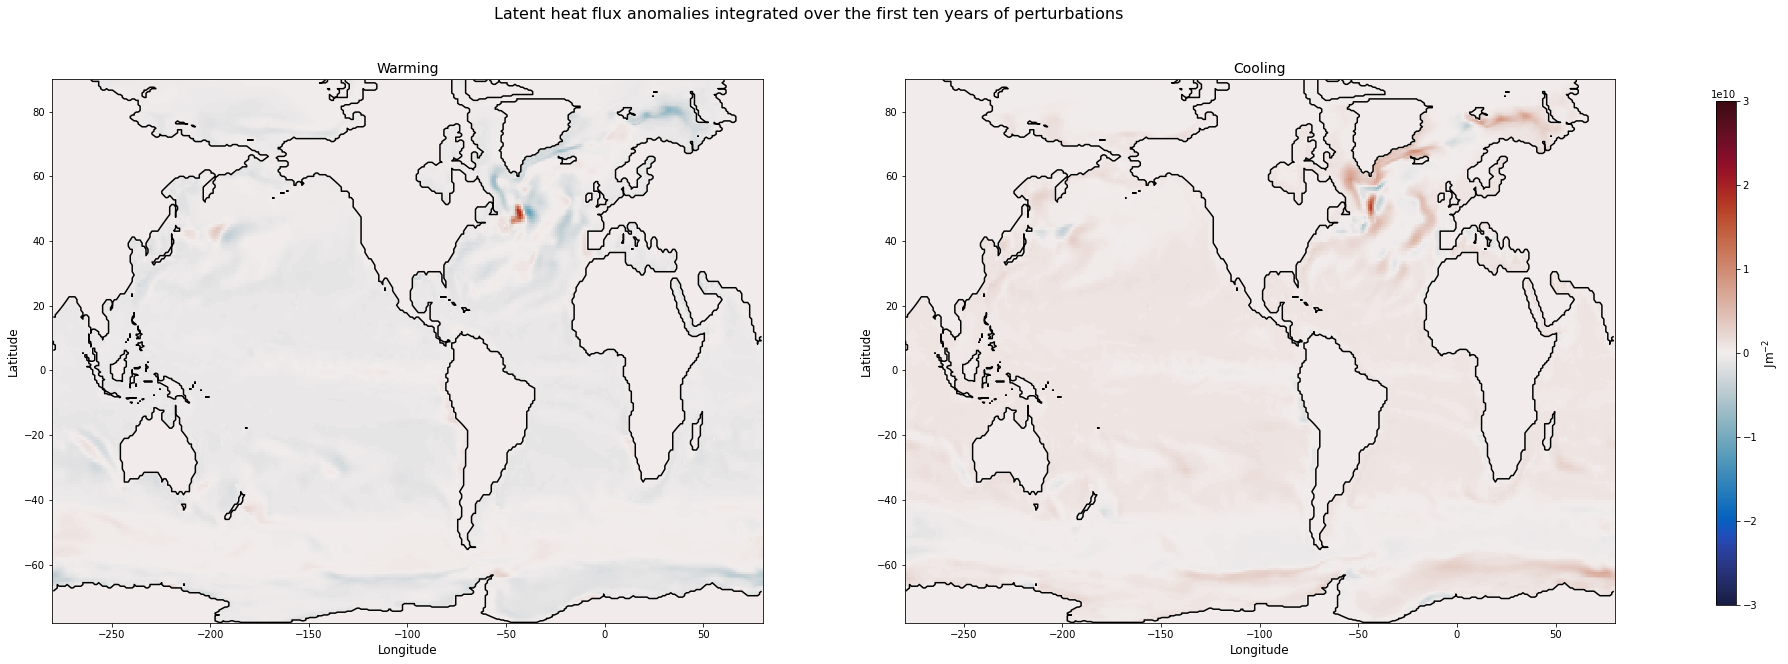

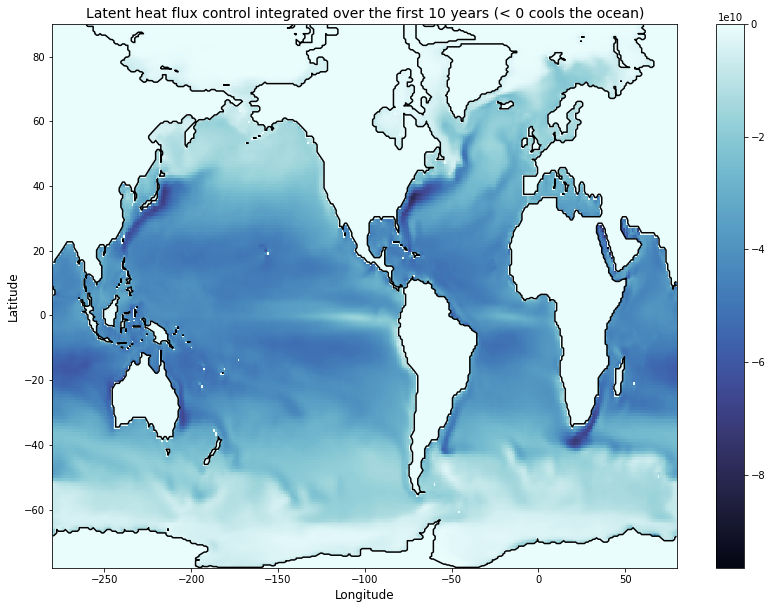

In [24]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(28, 10))
plt.suptitle('Latent heat flux anomalies integrated over the first ten years of perturbations', fontsize=16)
yr_10 = '2410-01-01'

month_length = evap_heat_cont.time.dt.days_in_month
p1 = ((evap_heat_warm - evap_heat_cont) * month_length * 24 * 3600).sel(time = slice(yr_beg, yr_10)).sum('time').plot(ax = axs[0], cmap = cm.cm.balance, vmin = -3e10, vmax = 3e10, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[0])
axs[0].set_title('Warming', fontsize=14)
axs[0].set_ylabel('Latitude', fontsize=12)
axs[0].set_xlabel('Longitude', fontsize=12)

p2 = ((evap_heat_cool - evap_heat_cont) * month_length * 24 * 3600).sel(time = slice(yr_beg, yr_10)).sum('time').plot(ax = axs[1], cmap = cm.cm.balance, vmin = -3e10, vmax = 3e10, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[1])
axs[1].set_title('Cooling', fontsize=14)
axs[1].set_ylabel('Latitude', fontsize=12)
axs[1].set_xlabel('Longitude', fontsize=12)

cb_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
cbar = fig.colorbar(p2, cax = cb_ax)
cbar.ax.set_ylabel('Jm$^{-2}$', fontsize = 12)
#plt.savefig('Latent heat flux.jpg')

plt.figure(figsize=(14,10))
((evap_heat_cont) * month_length * 24 * 3600).sel(time = slice(yr_beg, yr_10)).sum('time').plot(cmap = cm.cm.ice)
mask_array.plot.contour(colors = 'k', levels = [1])
plt.title('Latent heat flux control integrated over the first 10 years (< 0 cools the ocean)', fontsize=14)
plt.ylabel('Latitude', fontsize=12)
plt.xlabel('Longitude', fontsize=12)
#plt.savefig('latent_heat_flux_cont.jpg')

### 400 year spinup

In [19]:
### Control

expt = '1deg_jra55_ryf_cont'
yr_beg = '2299-01-16'
yr_end = '2349-12-16'

GAT_cont_400 = cc.querying.getvar(expt, 'temp_global_ave', session).sel(time = slice(yr_beg, yr_end)).groupby('time.year').mean('time').chunk(chunks='auto')
SST_cont_400 = cc.querying.getvar(expt, 'temp_surface_ave', session).sel(time = slice(yr_beg, yr_end)).groupby('time.year').mean('time')

In [7]:
### Cool

expt = '1deg_jra55_ryf_rcp45cool_spinup400'
cool = cc.querying.get_variables(session, experiment = expt)

GAT_cool_400 = cc.querying.getvar(expt, 'temp_global_ave', session).sel(time = slice(yr_beg, yr_end)).groupby('time.year').mean('time').chunk(chunks='auto')
SST_cool_400 = cc.querying.getvar(expt, 'temp_surface_ave', session).sel(time = slice(yr_beg, yr_end)).groupby('time.year').mean('time').chunk(chunks='auto')

In [8]:
### Warm

expt = '1deg_jra55_ryf_rcp45warm_spinup400'
cool = cc.querying.get_variables(session, experiment = expt)

GAT_warm_400 = cc.querying.getvar(expt, 'temp_global_ave', session).sel(time = slice(yr_beg, yr_end)).groupby('time.year').mean('time').chunk(chunks='auto')
SST_warm_400 = cc.querying.getvar(expt, 'temp_surface_ave', session).sel(time = slice(yr_beg, yr_end)).groupby('time.year').mean('time')

In [20]:
# Load into memory

GAT_cont_400 = GAT_cont_400.load()
SST_cont_400 = SST_cont_400.load()

In [10]:
GAT_cool_400 = GAT_cool_400.load()
SST_cool_400 = SST_cool_400.load()

In [11]:
GAT_warm_400 = GAT_warm_400.load()
SST_warm_400 = SST_warm_400.load()

In [21]:
### Dedrift using a cubic

def cubic(t, a, b, c, d):
    return a * t**3 + b * t**2 + c * t + d

t = GAT_cont_400['year'].values
popt, pcov = curve_fit(cubic, t, GAT_cont_400[:,0])
GAT_trend = cubic(t, *popt)

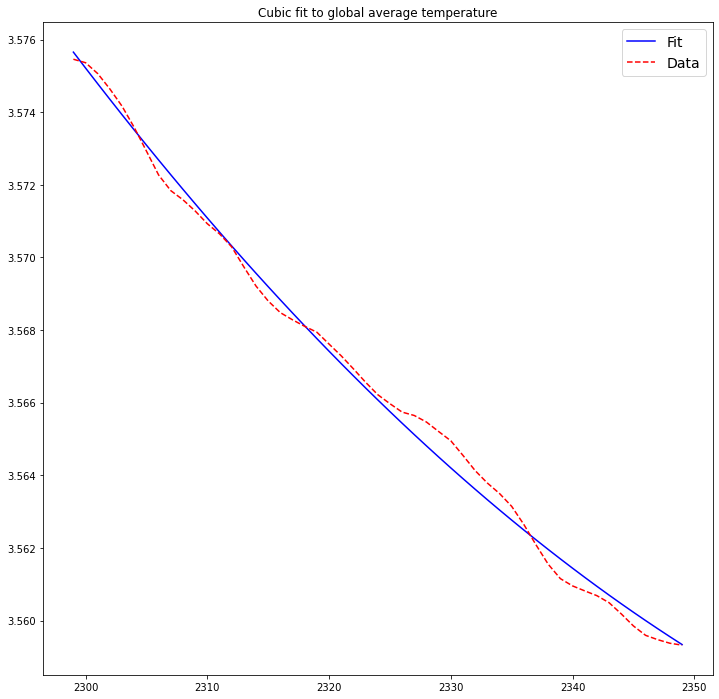

In [38]:
plt.figure(figsize=(12,12))
plt.plot(t[:51], GAT_trend[:51], label='Fit', color = 'b')
plt.plot(t[:51], GAT_cont_400[:51,0], label='Data', color = 'r', linestyle = '--')
plt.title('Cubic fit to global average temperature')
plt.legend(fontsize=14)

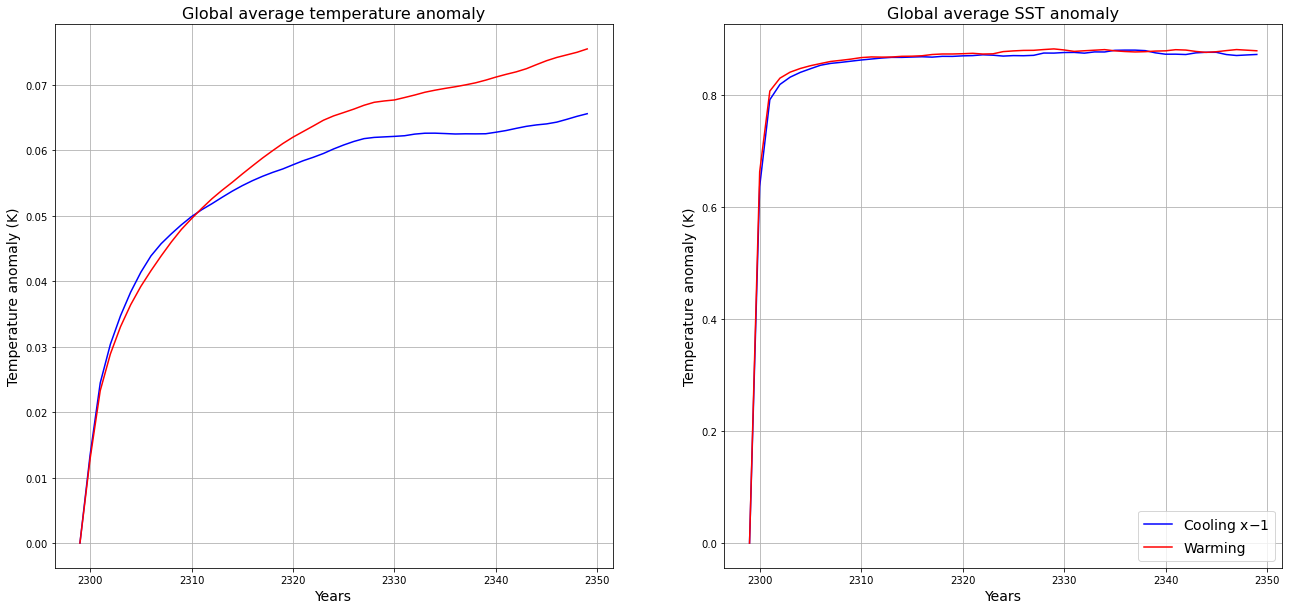

In [43]:
# GAT
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(22,10))

GAT_trend_2299 = xr.DataArray(data=[GAT_trend[0]], dims='year', coords={"year": [2299]})
GAT_cool_plotting = xr.concat([GAT_trend_2299, GAT_cool_400], dim='year')[:,0]
GAT_warm_plotting = xr.concat([GAT_trend_2299, GAT_warm_400], dim='year')[:,0]
(- 1 * (GAT_cool_plotting[:51] - GAT_trend[:51])).plot(ax = axs[0], color='b', label='Cooling x$-1$')
(GAT_warm_plotting[:51] - GAT_trend[:51]).plot(ax = axs[0], color='r', label='Warming')

axs[0].grid()
axs[0].set_title('Global average temperature anomaly', fontsize=16)
axs[0].set_xlabel('Years', fontsize=14)
axs[0].set_ylabel('Temperature anomaly (K)', fontsize=14)


# SST
SST_cool_plotting = xr.concat([SST_cont_400[0,:], SST_cool_400], dim='year')
SST_warm_plotting = xr.concat([SST_cont_400[0,:], SST_warm_400], dim='year')
(- 1 * (SST_cool_plotting[:51] - SST_cont_400[:51])).plot(ax = axs[1], color='b', label='Cooling x$-1$')
(SST_warm_plotting[:51] - SST_cont_400[:51]).plot(ax = axs[1], color='r', label='Warming')
axs[1].grid()
axs[1].legend(fontsize=14, loc='lower right')
axs[1].set_title('Global average SST anomaly', fontsize=16)
axs[1].set_xlabel('Years', fontsize=14)
axs[1].set_ylabel('Temperature anomaly (K)', fontsize=14)
plt.savefig('GAT_SST_spinup400.jpg')

## Surface heat fluxes